In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.sncdcgan as sncdcgan
import networks.utils as utils

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
NUM_FEATURE_VEC_CHANNELS = 37
BASE_NUM_OUT_CHANNELS_G = 128
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance"
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
BETA1 = 0.  #formerly 0.5
BETA2 = 0.9  #formerly 0.999
N_CRITIC = 5
LAMBDA_GP = 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "sncdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

#MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_18-31-20/gan_at_epoch_0001.pt")
MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                           num_workers=NUM_THREADS, pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


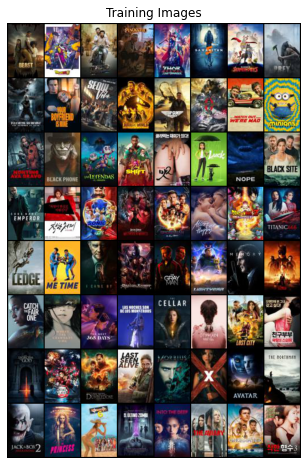

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

In [7]:
sample_labels = torch.stack(sample_reals[6:43], dim=1).type(torch.FloatTensor).to(device)[:NUM_SAMPLES]
sample_labels_generator = sample_labels[:, :, None, None].expand(NUM_SAMPLES, NUM_FEATURE_VEC_CHANNELS, 3, 1)

### Initialize Network

In [8]:
generator, discriminator = sncdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                               num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                               base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                               base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                               padding_mode=PADDING_MODE,
                                               num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS, device=device)

print("Generator:")
summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1), (NUM_FEATURE_VEC_CHANNELS, 3, 1)])
print("\nDiscriminator:")
summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-3            [-1, 512, 6, 4]         303,104
       BatchNorm2d-4            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-5           [-1, 512, 12, 8]       8,388,608
       BatchNorm2d-6           [-1, 512, 12, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 24, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 24, 16]             512
   ConvTranspose2d-9          [-1, 128, 48, 32]         524,288
      BatchNorm2d-10          [-1, 128, 48, 32]             256
  ConvTranspose2d-11            [-1, 3, 96, 64]           6,144
Total params: 12,142,336
Trainable params: 12,142,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

In [9]:
from contextlib import redirect_stdout

with open(path.join(OUT_PATH, "architectures.txt"), "w") as file:
    with redirect_stdout(file):
        print("Generator:")
        summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1), (NUM_FEATURE_VEC_CHANNELS, 3, 1)])
        print("\nDiscriminator:")
        summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

In [10]:
trainer = sncdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                                  num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                                  d_params=discriminator.parameters(), g_params=generator.parameters(),
                                  learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

In [11]:
SHOW_GRAPHS = False

trainer.train(generator, discriminator, num_features=NUM_FEATURE_VEC_CHANNELS, dataloader=posterloader,
              num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS,
              model_snap=SAVE_MODEL_EVERY_N_EPOCHS, model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS,
              sample_labels_generator=sample_labels_generator)

[0/4]	Loss_D: 0.7937	Loss_G: 2.0014	D(x): 0.7191	D(G(z)): 0.3506 / 0.1455: 100%|██████████| 3502/3502 [20:34<00:00,  2.84it/s]
[1/4]	Loss_D: 0.9714	Loss_G: 2.1138	D(x): 0.7082	D(G(z)): 0.4369 / 0.1319: 100%|██████████| 3502/3502 [20:07<00:00,  2.90it/s]
[2/4]	Loss_D: 0.8568	Loss_G: 2.2076	D(x): 0.7305	D(G(z)): 0.4091 / 0.1158: 100%|██████████| 3502/3502 [20:14<00:00,  2.88it/s] 
[3/4]	Loss_D: 0.8442	Loss_G: 1.4988	D(x): 0.6390	D(G(z)): 0.3146 / 0.2297: 100%|██████████| 3502/3502 [19:43<00:00,  2.96it/s]
[4/4]	Loss_D: 0.9250	Loss_G: 1.8342	D(x): 0.7008	D(G(z)): 0.4205 / 0.1697: 100%|██████████| 3502/3502 [19:51<00:00,  2.94it/s]


### Show results

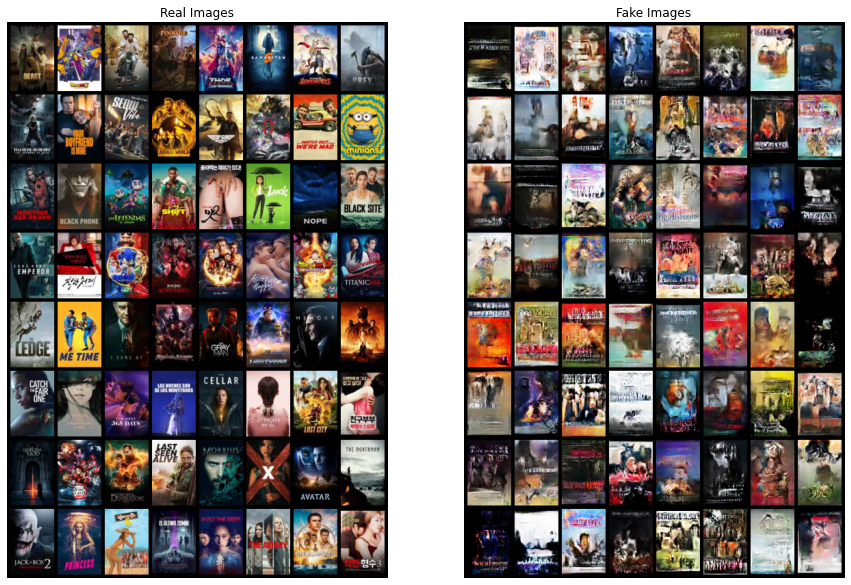

In [12]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device,
                          sample_labels_generator=sample_labels_generator)

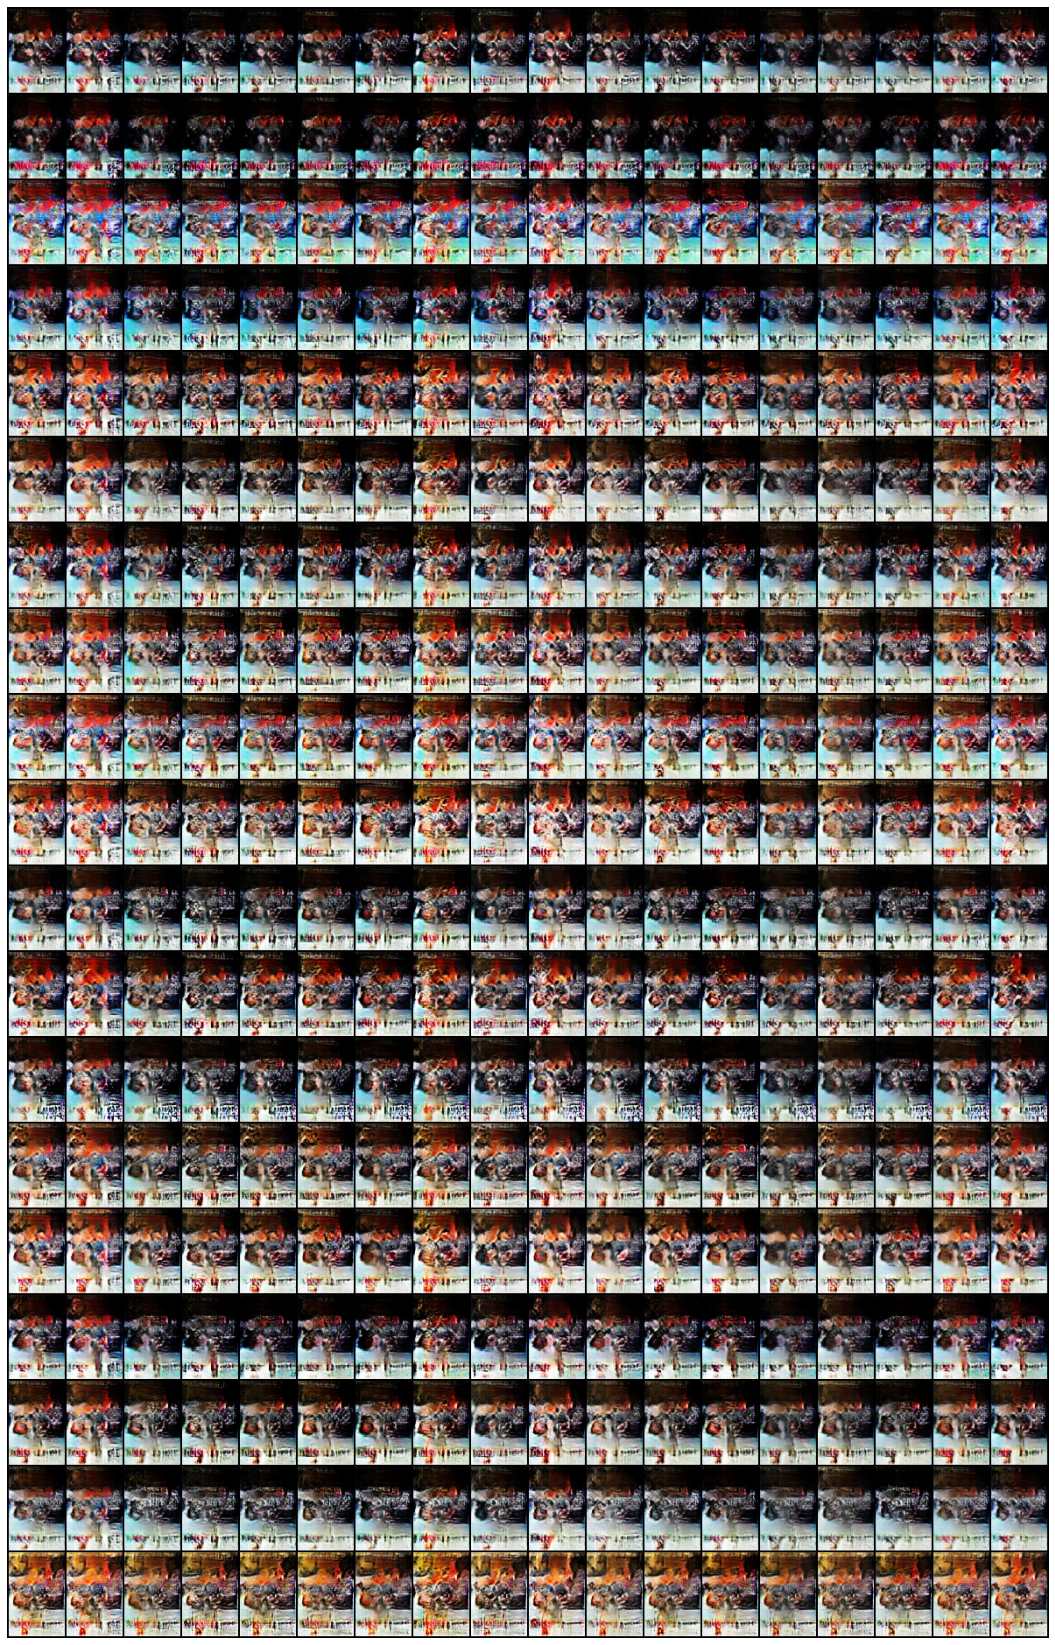

In [13]:
seed = 79469812346923649
utils.plot_grid(generator, NUM_NOISE_VEC_CHANNELS, device, seed, 20, 30,
                output=path.join(trainer.last_out_dir, "conditional_grid.png"))